In [178]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

In [151]:
ROOT = Path.cwd().resolve().parent
DATA = ROOT / "Data" / "December1999.txt"

In [152]:
df = pd.read_csv(DATA, sep='\t')
print(df.head())

  vru+line  call_id  customer_id  priority type    date vru_entry vru_exit  \
0   AA0101    49296          0.0         0   PS  991201   5:20:04  5:20:41   
1   AA0101    49297   67472894.0         2   PS  991201   7:22:53  7:22:58   
2   AA0101    49298   56165871.0         2   PS  991201   7:44:58  7:45:04   
3   AA0101    49299          0.0         0   PS  991201   8:06:40  8:06:48   
4   AA0101    49300   42791442.0         2   PS  991201   8:24:13  8:24:19   

   vru_time  q_start   q_exit  q_time outcome ser_start ser_exit  ser_time  \
0        37  0:00:00  0:00:00       0    HANG   0:00:00  0:00:00         0   
1         5  7:22:58  7:24:18      80   AGENT   7:24:17  7:30:09       352   
2         6  7:45:04  7:48:22     198   AGENT   7:48:21  7:49:16        55   
3         8  0:00:00  0:00:00       0   AGENT   8:06:47  8:09:25       158   
4         6  8:24:19  8:25:00      41   AGENT   8:25:00  8:28:01       181   

      server  
0  NO_SERVER  
1     ZOHARI  
2     GELBER  
3 

Como queremos simular una M/M/S necesitamos datos en donde hubo un servicio, por lo que los apartados NO_SERVER o ser_time = 0, no nos sirven

In [153]:
df = df[(df['server'] != 'NO_SERVER') & (df['ser_time']!=0)].copy()

También queremos los servicios donde el servicio fue el mismo, es decir queremos que vru+line sea el mismo para nuestros datos.

In [154]:
df[['vru+line']].value_counts()

vru+line
AA0216      1552
AA0116      1510
AA0201      1411
AA0207      1400
AA0208      1365
AA0213      1364
AA0214      1364
AA0109      1349
AA0203      1340
AA0103      1334
AA0206      1333
AA0104      1330
AA0115      1327
AA0209      1324
AA0210      1315
AA0106      1303
AA0110      1300
AA0113      1297
AA0101      1285
AA0215      1249
AA0202      1245
AA0204      1226
AA0105      1225
AA0205      1160
AA0102       840
AA0111       327
AA0107       319
AA0108       291
Name: count, dtype: int64

Agarraremos el servicio AA0216 porque es donde más datos hay

In [155]:
df = df[ df['vru+line'] == 'AA0216'].copy()
df

,vru+line,call_id,customer_id,priority,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server
40996,AA0216,15147,0.0,0,IN,991201,7:01:36,7:01:49,13,0:00:00,0:00:00,0,AGENT,7:01:48,7:08:31,403,Z2ARIE
40997,AA0216,15148,0.0,0,IN,991201,7:53:58,7:54:10,12,0:00:00,0:00:00,0,AGENT,7:54:09,7:56:44,155,Z2ARIE
40998,AA0216,15149,0.0,0,IN,991201,8:37:42,8:37:57,15,0:00:00,0:00:00,0,AGENT,8:37:56,8:39:01,65,Z2ARIE
40999,AA0216,15150,0.0,0,IN,991201,9:14:04,9:14:13,9,9:14:13,9:14:38,25,AGENT,9:14:37,9:21:18,401,Z2ARIE
41002,AA0216,15153,0.0,0,IN,991201,9:23:24,9:23:36,12,0:00:00,0:00:00,0,AGENT,9:23:35,9:26:15,160,Z2ARIE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43055,AA0216,17206,0.0,0,IN,991231,11:40:37,11:40:46,9,11:40:46,11:41:44,58,AGENT,11:41:43,11:51:52,609,Z2ARIE
43056,AA0216,17207,0.0,0,IN,991231,12:37:47,12:38:04,17,0:00:00,0:00:00,0,AGENT,12:38:03,12:41:07,184,Z2ARIE
43057,AA0216,17208,0.0,0,IN,991231,12:59:03,12:59:19,16,0:00:00,0:00:00,0,AGENT,12:59:18,13:05:47,389,Z2ARIE
43058,AA0216,17209,0.0,0,IN,991231,13:18:00,13:18:14,14,0:00:00,0:00:00,0,AGENT,13:18:13,13:18:30,17,Z2ARIE


Ahora eliminaremos las columnas que no sean de relevancia para la simulación

In [156]:
df['customer_id'].value_counts()

customer_id
0.0    1552
Name: count, dtype: int64

In [157]:
df['type'].value_counts()

type
IN    1552
Name: count, dtype: int64

In [158]:
df['priority'].value_counts()

priority
0    1552
Name: count, dtype: int64

In [159]:
df['outcome'].value_counts()

outcome
AGENT    1552
Name: count, dtype: int64

In [160]:
cols = ['customer_id', 'type','priority','outcome','call_id','vru_entry','vru_exit','vru_time']
df.drop(columns=cols, inplace=True)

Veamos cuantos servidores hay

In [161]:
df['server'].value_counts()

server
Z2EYAL       299
Z2NIRIT      292
Z2ARIE       259
Z2OFERZ      178
Z2ELINOR     169
Z2SPIEGEL    152
Z2ASSAF       84
Z2LIOR        57
GELBER        26
KAZAV         21
DORIT         11
ROTH           1
SHARON         1
ZIPI           1
AVI            1
Name: count, dtype: int64

In [162]:
df[df['date']==991201]

,vru+line,date,q_start,q_exit,q_time,ser_start,ser_exit,ser_time,server
40996,AA0216,991201,0:00:00,0:00:00,0,7:01:48,7:08:31,403,Z2ARIE
40997,AA0216,991201,0:00:00,0:00:00,0,7:54:09,7:56:44,155,Z2ARIE
40998,AA0216,991201,0:00:00,0:00:00,0,8:37:56,8:39:01,65,Z2ARIE
40999,AA0216,991201,9:14:13,9:14:38,25,9:14:37,9:21:18,401,Z2ARIE
41002,AA0216,991201,0:00:00,0:00:00,0,9:23:35,9:26:15,160,Z2ARIE
41004,AA0216,991201,9:29:11,9:34:43,332,9:34:42,9:36:08,86,Z2ARIE
41005,AA0216,991201,0:00:00,0:00:00,0,9:45:40,9:47:19,99,Z2SPIEGEL
41006,AA0216,991201,0:00:00,0:00:00,0,9:51:05,9:53:48,163,Z2SPIEGEL
41007,AA0216,991201,0:00:00,0:00:00,0,9:57:59,9:59:33,94,Z2SPIEGEL
41008,AA0216,991201,9:58:33,9:59:21,48,9:59:21,10:55:34,3373,Z2NIRIT


Podemos notar que aunque sean diferentes servidores no todos estan ocupados al mismo tiempo

In [164]:
servidores_por_fecha = df.groupby(['date'])['server'].unique()

In [165]:
servidores_por_fecha

date
991201       [Z2ARIE, Z2SPIEGEL, Z2NIRIT, Z2ELINOR, Z2EYAL]
991202    [Z2OFERZ, Z2LIOR, Z2EYAL, Z2NIRIT, Z2ARIE, GEL...
991203                          [Z2LIOR, Z2ELINOR, Z2OFERZ]
991204                                   [Z2EYAL, Z2ELINOR]
991205    [Z2ARIE, ROTH, Z2LIOR, Z2EYAL, Z2OFERZ, Z2NIRI...
991206    [Z2ARIE, Z2SPIEGEL, Z2ELINOR, Z2EYAL, Z2OFERZ,...
991207          [Z2SPIEGEL, Z2EYAL, DORIT, Z2NIRIT, Z2ARIE]
991208       [Z2SPIEGEL, Z2NIRIT, Z2ARIE, Z2ELINOR, GELBER]
991209                    [Z2ARIE, Z2LIOR, Z2NIRIT, Z2EYAL]
991210                             [Z2ARIE, Z2EYAL, Z2LIOR]
991211                                   [Z2NIRIT, Z2OFERZ]
991212                   [Z2NIRIT, Z2ARIE, Z2EYAL, Z2OFERZ]
991213        [Z2SPIEGEL, Z2ARIE, GELBER, Z2ELINOR, Z2EYAL]
991214                         [Z2SPIEGEL, Z2ARIE, Z2NIRIT]
991215               [Z2SPIEGEL, Z2NIRIT, Z2ARIE, Z2ELINOR]
991216                   [Z2ARIE, Z2OFERZ, Z2NIRIT, Z2LIOR]
991217                          [Z2

La distribucion de servidores por dia es distinta

In [166]:
servers_dia = []
for i in range(31):
    size = len(servidores_por_fecha.iloc[i])
    servers_dia.append(size)

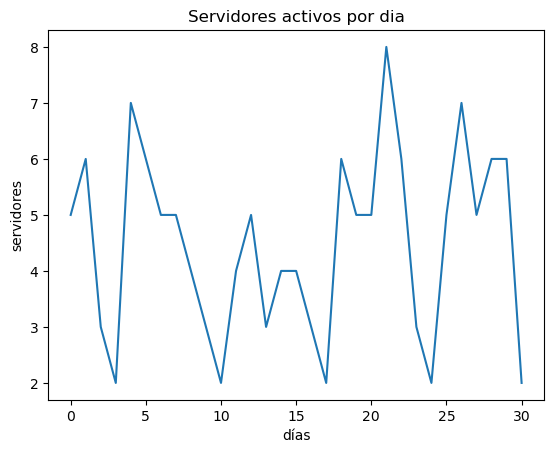

In [167]:
plt.plot(range(31), servers_dia)
plt.title('Servidores activos por dia')
plt.xlabel('días')
plt.ylabel('servidores')
plt.show()

Pero los servidores son las personas que atienden, no las 'cajas', veamos si podemos decir que tenemos una o dos cajas

In [176]:
def detector_cajas(fecha):
    num_colas = 0
    data = df[df['date']==fecha]
    cola = []

    for i in range(len(data)):
        h1 = data.iloc[i]['ser_start']
        h2 = data.iloc[i]['ser_exit']
        t_start = datetime.strptime(h1, "%H:%M:%S").time()
        borrar = []

        for j, (h3, h4) in enumerate(cola[:]):
            old_exit = datetime.strptime(h4, "%H:%M:%S").time()
            if old_exit <= t_start:
                borrar.append(j) 

        for l in sorted(borrar, reverse=True):
            cola.pop(l)

        cola.append((h1,h2)) 
        num_colas = max(num_colas,len(cola))
    return num_colas

In [170]:
colas = set()
for date in df['date'].unique():
    colas.add(detector_cajas(date))
print(colas)

{1, 2, 3}


Podemos ver que nuestros datos se pueden simular con 3 cajas de atencion.

Ahora vamos a etiquetar esas cajas en nuestro dataset

In [171]:
df['caja'] = 0

In [172]:
def etiquetador_cajas(fecha):
    num_colas = 0
    data = df[df['date']==fecha]
    idx = data.index
    cola = []

    for i in idx:
        h1 = data.loc[i]['ser_start']
        h2 = data.loc[i]['ser_exit']
        t_start = datetime.strptime(h1, "%H:%M:%S").time()
        borrar = []

        for j, (h3, h4) in enumerate(cola[:]):
            old_exit = datetime.strptime(h4, "%H:%M:%S").time()
            if old_exit <= t_start:
                borrar.append(j) 

        for l in sorted(borrar, reverse=True):
            cola.pop(l)

        cola.append((h1,h2)) 
        num_colas = max(num_colas,len(cola))
        df.loc[i, 'caja'] = len(cola)
    return num_colas

In [173]:
for date in df['date'].unique():
    etiquetador_cajas(date)
df

,vru+line,date,q_start,q_exit,q_time,ser_start,ser_exit,ser_time,server,caja
40996,AA0216,991201,0:00:00,0:00:00,0,7:01:48,7:08:31,403,Z2ARIE,1
40997,AA0216,991201,0:00:00,0:00:00,0,7:54:09,7:56:44,155,Z2ARIE,1
40998,AA0216,991201,0:00:00,0:00:00,0,8:37:56,8:39:01,65,Z2ARIE,1
40999,AA0216,991201,9:14:13,9:14:38,25,9:14:37,9:21:18,401,Z2ARIE,1
41002,AA0216,991201,0:00:00,0:00:00,0,9:23:35,9:26:15,160,Z2ARIE,1
...,...,...,...,...,...,...,...,...,...,...
43055,AA0216,991231,11:40:46,11:41:44,58,11:41:43,11:51:52,609,Z2ARIE,1
43056,AA0216,991231,0:00:00,0:00:00,0,12:38:03,12:41:07,184,Z2ARIE,1
43057,AA0216,991231,0:00:00,0:00:00,0,12:59:18,13:05:47,389,Z2ARIE,1
43058,AA0216,991231,0:00:00,0:00:00,0,13:18:13,13:18:30,17,Z2ARIE,1


Veamos la distribución de las cajas

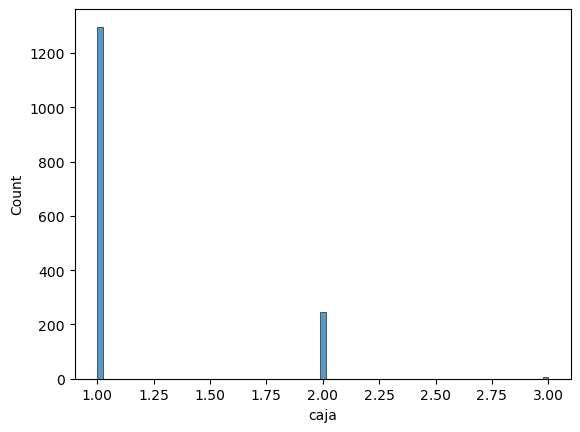

In [182]:
sns.histplot(df['caja']);

Guardamos el dataset listo para usarse en simulación

In [185]:
df.to_csv("../Data/clean_data.csv", index=False)